# Converting to .py: total=292, successful=239

e.g.:
- Notebook does not appear to be JSON
- UnicodeDecodeError: \'utf-8\' codec can\'t decode byte 0x92 in position 26298: invalid start byte

In [1]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

df=pandas.read_csv('../scripts/func_report1.csv')
df

df.print
print
np.print

print(df)
print("")

,Function,Counter,Kernel
0,print,9,D:\sample1\allen-institute-for-ai\CORD-19-rese...
1,open,4,D:\sample1\allen-institute-for-ai\CORD-19-rese...
2,get_ipython,3,D:\sample1\allen-institute-for-ai\CORD-19-rese...
3,nlp,2,D:\sample1\allen-institute-for-ai\CORD-19-rese...
4,list,2,D:\sample1\allen-institute-for-ai\CORD-19-rese...
...,...,...,...
1823,loud,1,D:\sample1\yamaerenay\spotify-dataset-19212020...
1824,energy,1,D:\sample1\yamaerenay\spotify-dataset-19212020...
1825,str,1,D:\sample1\yamaerenay\spotify-dataset-19212020...
1826,get_ipython,1,D:\sample1\yamaerenay\spotify-dataset-19212020...


In [2]:
most_common = df.groupby('Function').sum().sort_values(by=['Counter'], ascending=False).reset_index()
most_common.head(15)

,Function,Counter
0,print,1195
1,len,397
2,range,216
3,dict,192
4,list,173
5,get_ipython,155
6,str,103
7,train_test_split,82
8,confusion_matrix,77
9,round,57


In [3]:
front_end = ['print', 'get_ipython', 'show', 'set_title', 'title', 'subplit', 'set_ylabel', 'set_xlabel', 'subplot', 'heatmap','subplots', 'histplot','plot','ylabel']
mc_trimmed = most_common[~most_common['Function'].isin(front_end)]
mc_trimmed.head(15)

#filter pandas
#

,Function,Counter
1,len,397
2,range,216
3,dict,192
4,list,173
6,str,103
7,train_test_split,82
8,confusion_matrix,77
9,round,57
10,accuracy_score,53
11,int,51


In [4]:
# Small Problem: What about syntax sugar?

import pandas as pd
dates = pd.date_range('1/1/2000', periods=3)

df = pd.DataFrame(np.random.randn(3, 4),
    index=dates, columns=['A', 'B', 'C', 'D'])
df

,A,B,C,D
2000-01-01,0.831620,0.262213,-0.226570,1.253785
2000-01-02,0.173807,0.807113,0.133586,1.147400
2000-01-03,0.778891,-0.244315,0.536202,-0.006810


In [5]:
df[['A','B']] # projection

,A,B
2000-01-01,0.831620,0.262213
2000-01-02,0.173807,0.807113
2000-01-03,0.778891,-0.244315


In [6]:
df['A'] = 'kernel'

In [7]:
df.__getitem__(['A','B']) # same thing

,A,B
2000-01-01,kernel,0.262213
2000-01-02,kernel,0.807113
2000-01-03,kernel,-0.244315


In [8]:
df[df['A']>0] # selection

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
df.__getitem__(df.__getitem__('A')>0) # same thing

Selections and projections both use the \_\_getitem\_\_ function. They are only differentiated by the type of parameter passed:
```python
df.__getitem__(ITERABLE: e.g. list or str) # projection
df.__getitem__(boolean DataFrame) # selection
```

# Big Problem: Where does the function come from?

e.g. __append__: __Pandas__ has append, __Numpy__ has append, Python __list__ has append or the user might have provided a __UDF__ named append


## Also relevant for the optimizer

E.g. my optimizer currently treats all '.merge()' calls the same. I can't guarantee that other libraries don't have .merge

## Solution 1: Astroid

``` python
from astroid import parse
module = parse('''
def func(first, second):
    return first + second

arg_1 = 2
arg_2 = 3
func(arg_1, arg_2)
''')
>>> module.body[-1]
<Expr l.3 at 0x10ab46f28>
>>> inferred = next(module.body[-1].value.infer())
>>> inferred
<Const.int l.None at 0x10ab00588>
>>> inferred.value
5
```

## Solution 2: python-rope

```python
l1 = [C()]
var1 = l1.pop() # python-rope knows that var1 is type C
``` 

## Rope is also a refactoring library:

```python
def pow(x, y):
    result = 1
    for i in range(y):
        result *= x
    return result

pow(2, 3)
```


``` bash
pattern: pow(${param1}, ${param2})
goal: ${param1} ** ${param2}
```

``` python
2 ** 3
```

Also easily done with AST/redbaron 😕

But what if:
```python
# pandas_api.py
def pow(x, y):
    result = 1
    for i in range(y):
        result *= x
    return result

# wflow.py
import pandas_api
mypow = pandas_api.pow
mypow(2, 3)
```

```bash
pattern: ${pow_func}(${param1}, ${param2})
goal: ${param1} ** ${param2}
pow_func: name=pandas_api.pow
```

```python
2 ** 3
```



## 🤔 Why am I telling you this?

Our optimizer = Cost based refactor tool

```python
import pandas as pd
a = pd.read_sql('blah')
b = a.__getitem__('Col1') # projection
action(b)

dictionary = dict()
c = dictionary['some_key'] # same syntax, diffent object type
```

Result:

```python
import pandas as pd
import psycopg
psycopg.execute_sql('CREATE VIEW a AS blah') # previously pd.read_sql
psycopg.execute_sql('CREATE VIEW b AS SELECT Col1 FROM a') # previously b=a['Col1']
action(pd.read_sql('SELECT * FROM b') # previously action(b)

dictionary = dict()
c = dictionary['some_key'] # untouched
```

So -> Ditch ast/redbaron, use rope instead

## Dynamic Object Analysis (DOA):

```python
def f(arg):
    return eval(arg) # SOA fails here

a_var = f('C')
```

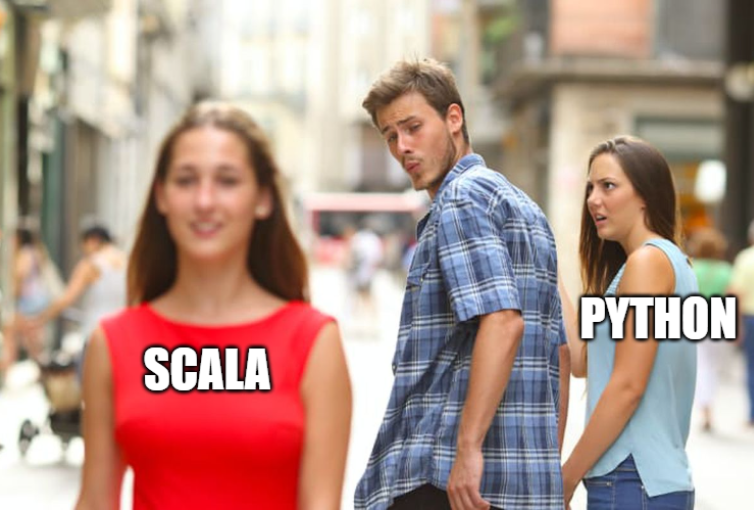

In [ ]:
import networkx as nx
g=nx.connected_caveman_graph(1,8)
color_map = []
for node in g:
    if node < 1:
        color_map.append('red')
    else: 
        color_map.append('green')      
nx.draw(g, node_color=color_map, with_labels=True)
# dotformat = nx.nx_agraph.to_agraph(g)
# graphimage = dotformat.draw(format='png', prog='dot')
# IPython.display.Image(graphimage, *args, **kwargs)

__Harry's work:__

Green node = RDBMS

Red node = Controller

In [ ]:
import networkx as nx
g=nx.balanced_tree(8,1)
color_map = []
for node in g:
    if node < 1:
        color_map.append('red')
    else: 
        color_map.append('green')      
nx.draw(g, node_color=color_map, with_labels=True)


__This work:__

Green node = RDBMS

Red node = Python

In [ ]:
import networkx as nx
g=nx.balanced_tree(8,1)
color_map = []
for node in g:
    if node < 1:
        color_map.append('red')
    elif node <5:
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(g, node_color=color_map, with_labels=True)


__Even more interesting:__

Green node = RDBMS

Blue node = RDBMS & Python

Red node = Python

In [ ]:
g=nx.connected_caveman_graph(1,8)
color_map = []
for node in g:
    if node < 1:
        color_map.append('red')
    elif node < 5:
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(g, node_color=color_map, with_labels=True)

__Combined:__

Blue node = Python & RDBMS

Red node = Controller & Python

Green node = RDBMS only

In [ ]:
import networkx as nx
g=nx.connected_caveman_graph(1,8)
color_map = []
for node in g:
    if node < 1:
        color_map.append('purple')
    elif node < 5:
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(g, node_color=color_map, with_labels=True)

Blue node = Python & RDBMS

Purple node = Controller & Python & local RDBMS

Green node = RDBMS only

# Gadfly: Pure Python 2 RDBMS

Proof of concept that the controller node can be treated as an RDBMS

## Sergey's idea about pushing python results back to the RDBMS during workflow execution

Now we can represent Python results as external VIEWS to the controller RDBMS. The worker RDBMSes will wait on the controller RDBMS to give them results, which in turn will be populated when the python script has executed the required code